In [1]:
import sys, os, time, shutil, random
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn, optim as opt
import torch.nn.functional as F
import torch.distributions as distrib
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt

# from src.helix import helix_labels, helix_observations, ToyVAE
from src.shapes import ShapesVAE, Shapes3D
from src.responses import response_mat, conditioned_response_mat, score_from_conditioned_response_mat
from src.maps import response_map_2d, compute_divergence_2d, compute_mean_curvature_2d, plot_map, \
    plot_posterior_2d, collect_posterior_means, push_forward, generate_2d_latent_map, plot_recs
from src import utils

# import omnifig as fig

# from omnilearn import util

In [2]:
device = 'cuda'
torch.manual_seed(67280421310721)

# Loading the Model

In [3]:
model = ShapesVAE()
model.load_state_dict(torch.load('model_a.pt'))
for _p in model.parameters(): _p.requires_grad = False
model.to(device)

ShapesVAE(
  (encoder): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
      (nonlin): ELU(alpha=1.0)
    )
    (3): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2

# Loading the Data

In [4]:
# data = Shapes3D(download=False, root=r'C:\Users\anwan\Documents\workspace\local_data\3dshapes')
data = Shapes3D(download=False)
len(data)

480000

Example Observations


<IPython.core.display.Javascript object>


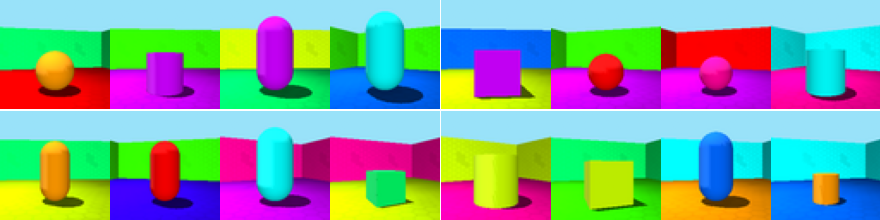

In [5]:
X, _ = data[torch.randint(len(data), size=(16,))]
print('Example Observations')
utils.plot_imgs(X, H=2, figsize=(8,2));

Reconstructions


<IPython.core.display.Javascript object>


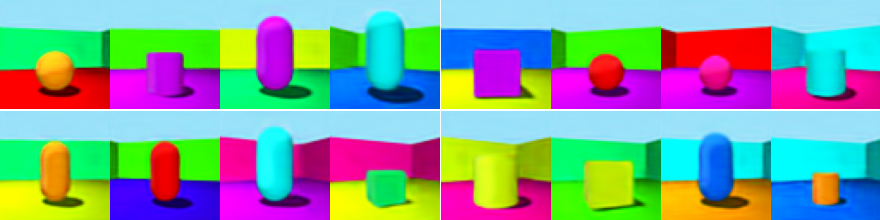

In [6]:
R = model.reconstruct(X.cuda()).cpu()
print('Reconstructions')
utils.plot_imgs(R, H=2, figsize=(8,2));

# Latent Response Matrix

By intervening on one latent dimension at a time and measuring the response, we can identify how the latent dimensions affect one another. 

In [7]:
mat = response_mat(model, device=device, pbar=tqdm, num_samples=128)
mat.shape

  0%|          | 0/24 [00:00<?, ?it/s]

torch.Size([24, 24])

<IPython.core.display.Javascript object>


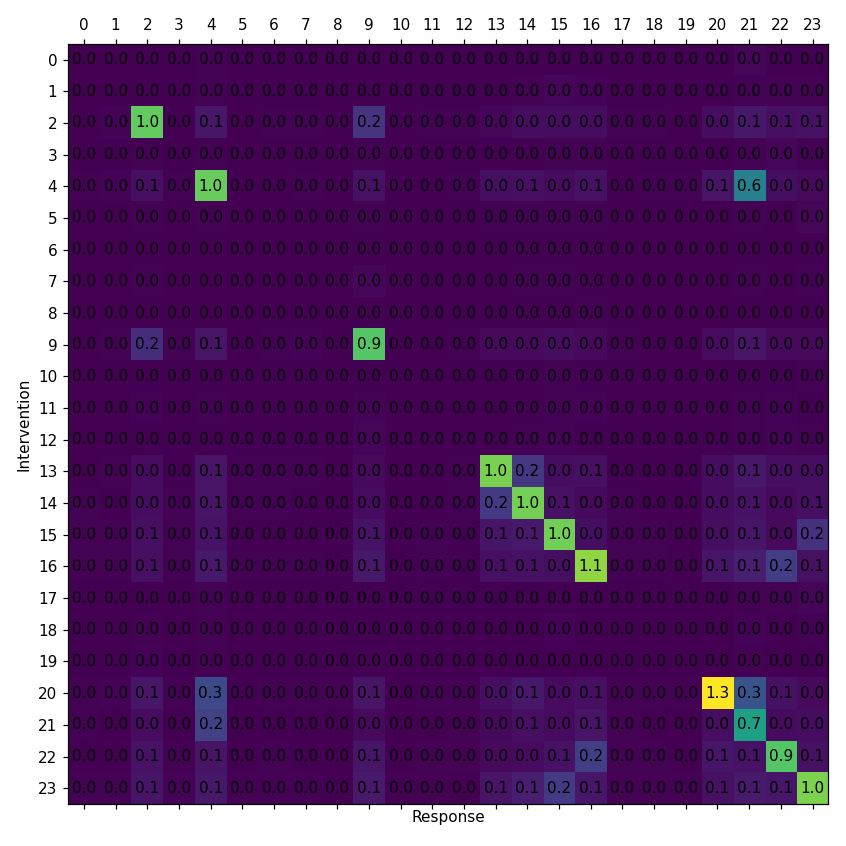

In [8]:
utils.plot_mat(mat, val_fmt='.1f', figside=0.3,);
plt.ylabel('Intervention')
plt.xlabel('Response')
plt.tight_layout();

# Conditioned Response Matrix and Causal Disentanglement Score

When the ground truth generative process is available (such as with synthetic datasets like 3D-Shapes), we can condition the interventions used to compute the latent response matrix on individual true factors to compute the "conditioned response matrix".

<IPython.core.display.Javascript object>


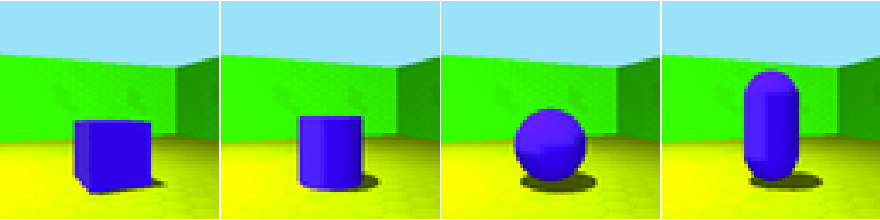

In [9]:
utils.plot_imgs(data.factor_traversal_images('shape'), H=1, figsize=(8,2));

In [10]:
cond_mat = conditioned_response_mat(model, data, device=device, num_traversals=20, pbar=tqdm)
cond_mat.shape

floor_hue:   0%|          | 0/20 [00:00<?, ?it/s]

wall_hue:   0%|          | 0/20 [00:00<?, ?it/s]

object_hue:   0%|          | 0/20 [00:00<?, ?it/s]

scale:   0%|          | 0/20 [00:00<?, ?it/s]

shape:   0%|          | 0/20 [00:00<?, ?it/s]

orientation:   0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([6, 24])

<IPython.core.display.Javascript object>


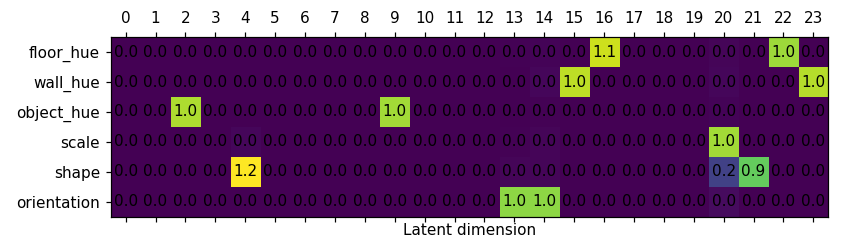

In [11]:
utils.plot_mat(cond_mat, val_fmt='.1f', figside=0.3,);
plt.yticks(range(len(data.factor_order)), data.factor_order)
plt.xlabel('Latent dimension');
plt.tight_layout();

In [12]:
score = score_from_conditioned_response_mat(cond_mat)
print(f'Causal Disentanglement Score: {score:2.4f}')

Causal Disentanglement Score: 0.9615


# Response Maps

In [13]:
dims = 4, 21

In [14]:
r = 2
n = 100
extent = [-r, r, -r, r]
base = model.sample_prior()
umap = response_map_2d(model, *dims, base=base, n=n, extent=extent, batch_size=256, device=device, pbar=tqdm)
mmap = umap.norm(p=2,dim=-1)
dmap = compute_divergence_2d(umap)
cmap = compute_mean_curvature_2d(umap)

/is/ei/fleeb/miniconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


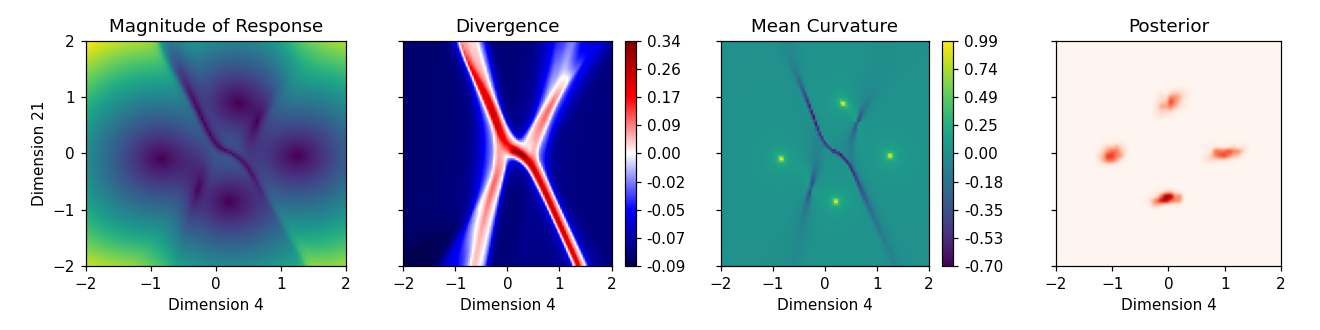

  0%|          | 0/2048 [00:00<?, ?it/s]

In [15]:
im_kwargs = dict(aspect = 'auto', extent=extent)
fg, axs = plt.subplots(1,4, figsize=(12,3),sharex=True, sharey=True)
plot_map(mmap, fgax=(fg,axs[0]), rescale=False, colorbar=False, **im_kwargs);
plt.title('Magnitude of Response')
plt.ylabel(f'Dimension {dims[1]}')
plt.xlabel(f'Dimension {dims[0]}')

plot_map(dmap, fgax=(fg,axs[1]), cmap='seismic', colorbar=True, **im_kwargs);
plt.title('Divergence')
plt.xlabel(f'Dimension {dims[0]}')

plot_map(cmap, fgax=(fg,axs[2]), cmap='viridis', colorbar=True, **im_kwargs);
plt.title('Mean Curvature')
plt.xlabel(f'Dimension {dims[0]}')

Z = collect_posterior_means(model, data, num_samples=2048, device=device, batch_size=256, pbar=tqdm)
plot_posterior_2d(Z, *dims, fgax=(fg,axs[3]), bins=n//2, extent=extent)
plt.title('Posterior')
plt.xlabel(f'Dimension {dims[0]}')
plt.tight_layout();

And the decoded observations corresponding the same slice of the latent space.

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


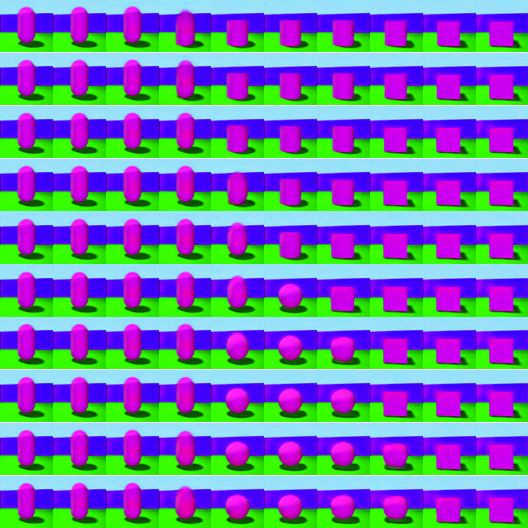

In [16]:
plot_recs(model, *dims, base=base, n=10, extent=extent, batch_size=256, device=device, pbar=tqdm);